In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

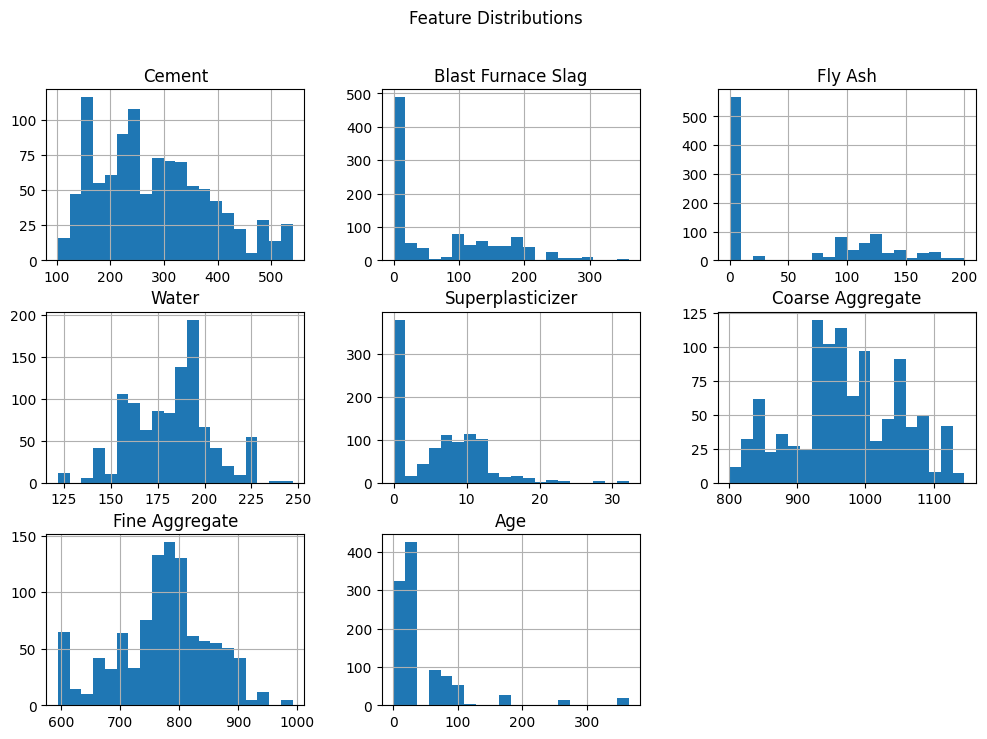

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

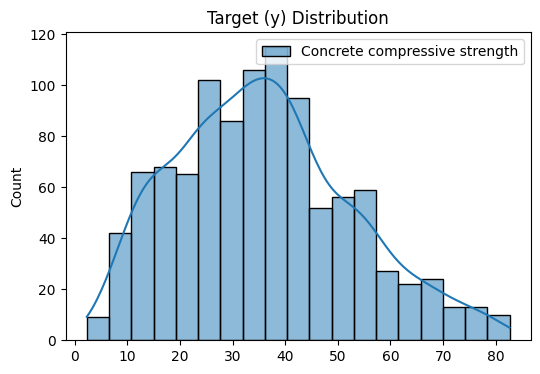

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

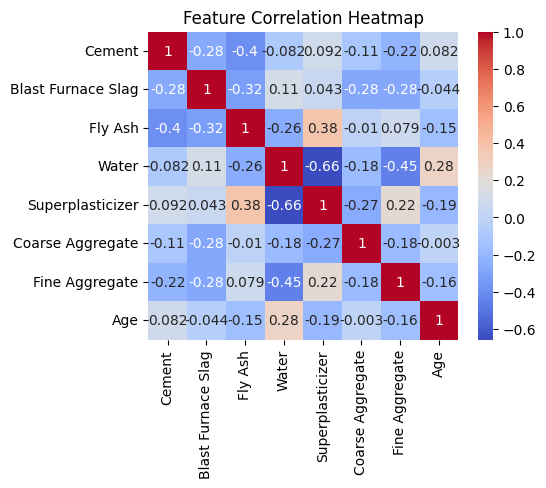

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.247082                 1.456602             1.298648   
1                  1.117007                 1.321852             1.243813   
2                  1.321934                 1.269853             1.074190   
3                  1.213800                 2.031019             1.194201   
4                  1.105770                 1.421644             1.137436   
mean               1.201118                 1.500194             1.189658   
std                0.090879                 0.306067             0.087881   

      DefaultBART_Rhat_RMSE  
0                  1.192794  
1                  1.301139  
2                  1.193205  
3                  1.523785  
4                  1.563900  
mean               1.354965  
std                0.178548  


In [9]:
rhat_df.to_csv("results/real4_Concrete_rhat.csv", index=False)

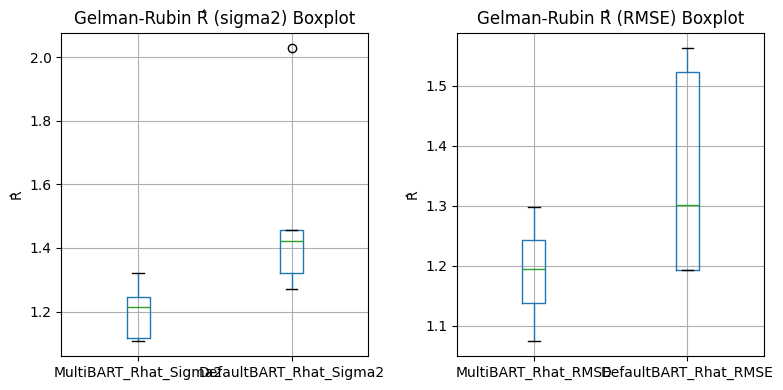

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh       bart        btz        sto         rf        xgb
0     20.329581  22.538970  25.070427  22.592307  25.337002  22.455559
1     22.476396  28.105991  28.935987  26.497917  28.011630  22.121190
2     20.344141  22.083502  27.365149  27.516044  22.319608  20.070588
3     20.676923  25.282306  21.843058  24.802949  24.326422  20.167277
4     17.638641  20.972455  24.670745  19.862792  24.962981  20.543163
5     18.332251  20.816401  20.177562  22.958426  26.308469  19.923279
6     19.081021  22.096102  24.021152  24.750890  25.070558  20.328900
7     16.651440  22.043076  21.750399  20.690338  21.417550  14.329891
8     19.333938  21.227278  20.759541  22.931403  31.274851  32.522720
9     19.337807  21.663060  20.265091  22.346946  25.410759  25.434845
mean  19.420214  22.682914  23.485911  23.495001  25.443983  21.789741
std    1.658420   2.282028   3.044407   2.409974   2.767778   4.683846



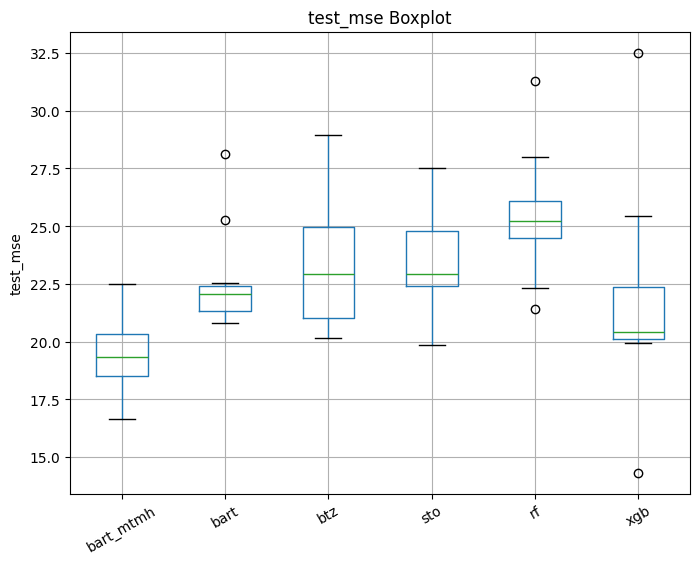

train_mse:
      bart_mtmh       bart        btz        sto        rf       xgb
0      7.011386  12.470032  13.403299  13.134910  4.507947  1.485153
1      7.309459  12.544634  11.047424  16.219434  4.546035  1.495007
2      7.374977  13.826916  12.223466  15.450676  4.560098  1.395256
3      6.269611  12.262327  12.572971  15.111675  4.021529  1.089786
4      6.301376  14.634104  13.771861  13.359264  4.354594  1.349169
5      6.823235  12.113671  11.144971  15.548964  4.597305  1.337065
6      6.190732  10.865570  11.922095  16.318870  4.637098  1.315198
7      7.326561  13.370709  13.158982  16.449662  4.734191  1.460623
8      5.068985  12.342973  12.462128  14.874934  3.413750  0.405178
9      6.837928  13.328023  11.993146  15.128894  3.984985  0.462414
mean   6.651425  12.775896  12.370034  15.159728  4.335753  1.179485
std    0.714212   1.048932   0.901795   1.144678  0.410202  0.409934



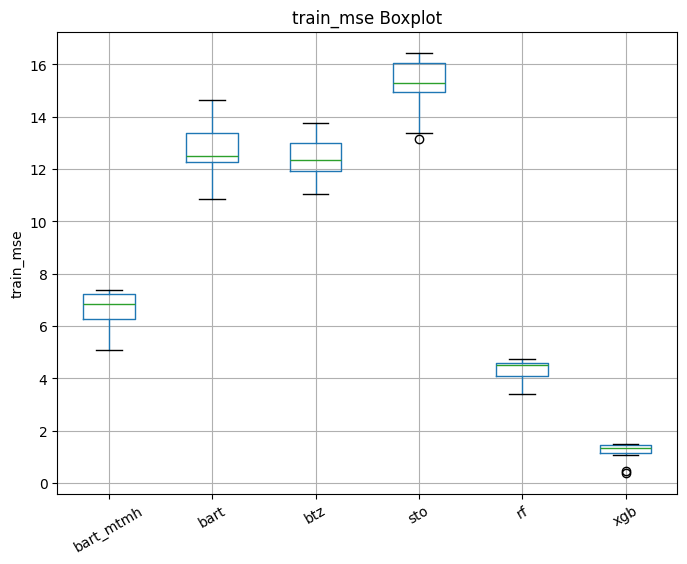

pi_length:
      bart_mtmh       bart        btz        sto
0     13.291688  15.676083  19.121891  60.713739
1     13.603206  15.706962  18.649112  76.162022
2     13.296441  15.664989  21.055038  72.730609
3     12.459249  14.613132  18.855695  72.304774
4     12.806179  16.665467  19.292985  69.322410
5     13.233405  15.238831  19.350978  69.680583
6     13.142937  14.954473  19.615386  84.314686
7     13.911535  16.197318  19.338820  73.445842
8     11.246875  15.576458  20.289941  80.817766
9     13.042378  15.946190  18.714007  61.283920
mean  13.003389  15.623990  19.428385  72.077635
std    0.733919   0.591530   0.744991   7.484406



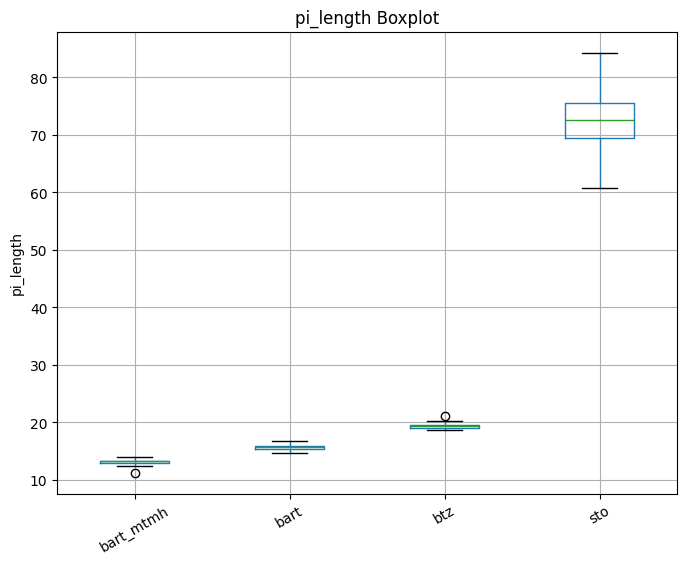

coverage:
      bart_mtmh      bart       btz       sto
0      0.906977  0.899225  0.945736  0.988372
1      0.875969  0.872093  0.945736  0.992248
2      0.875969  0.914729  0.941860  1.000000
3      0.864341  0.883721  0.953488  0.996124
4      0.941860  0.945736  0.953488  1.000000
5      0.926357  0.922481  0.949612  0.996124
6      0.895349  0.879845  0.953488  0.988372
7      0.899225  0.906977  0.957364  1.000000
8      0.856589  0.918605  0.957364  0.992248
9      0.903101  0.922481  0.941860  0.980620
mean   0.894574  0.906589  0.950000  0.993411
std    0.026965  0.022927  0.005907  0.006343



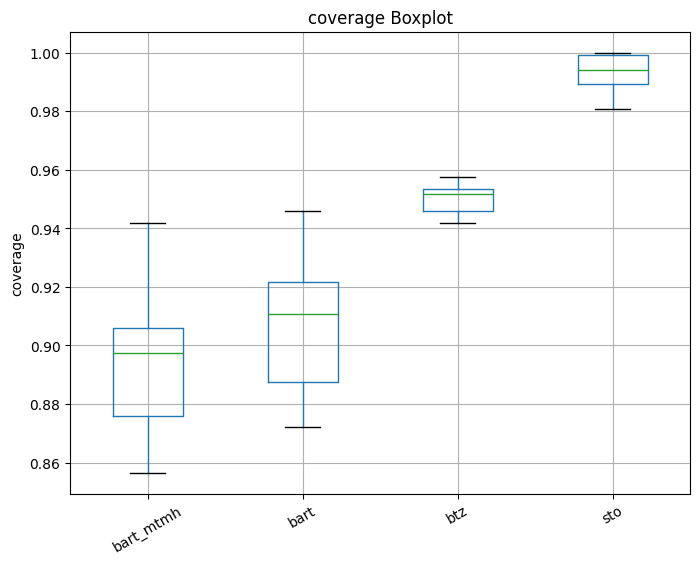

train_time:
      bart_mtmh      bart       btz       sto        rf       xgb
0      8.229005  1.200106  5.888069  0.963674  0.409566  0.220121
1      8.039212  1.077054  5.531440  1.041712  0.351809  0.301084
2      8.059213  1.106899  5.490825  1.005446  0.359827  0.319101
3      8.087267  1.091868  5.498841  0.991421  0.351814  0.364328
4      8.189062  1.171182  5.674309  0.976151  0.445404  0.240317
5      9.197585  1.090175  4.810799  1.202735  0.460985  0.435786
6      9.070585  1.165139  4.961817  1.488782  0.467219  0.171361
7      9.107522  1.133247  5.340433  1.354753  0.535128  0.248459
8      9.196094  1.208413  5.823297  1.255086  0.362504  0.188676
9      9.089513  1.194444  6.033713  0.991172  0.400114  0.187809
mean   8.626506  1.143853  5.505354  1.127093  0.414437  0.267704
std    0.537525  0.050128  0.388907  0.186551  0.061671  0.086048



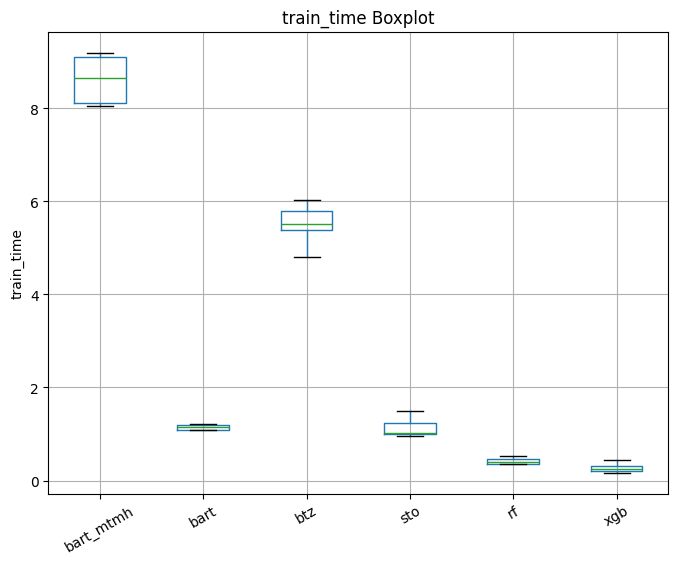

In [11]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [12]:
for k, v in mse_results.items():
    csv_name = f"results/real4_Concrete_{k}.csv"
    v.to_csv(csv_name, index=False)